# Portland Trail Blazers - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [101]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [102]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [106]:
lkupclientid = 5 # Portland Trail Blazers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(11004, 55)

### Let's drop the features that have lots of null values, and any ID columns, as these won't be useful to our model:

In [107]:
df.drop([
    'dimCustomerMasterId',
    'source_tenure',
    'urbanicity', 
    'isnextyear_buyer', 
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.shape

(11004, 48)

### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [108]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(11004, 30)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [111]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   renewedBeforeDays    11004 non-null  int64  
 1   tenure               11004 non-null  int64  
 2   totalGames           11004 non-null  int64  
 3   recency              11004 non-null  int64  
 4   missed_games_1       11004 non-null  int64  
 5   missed_games_2       11004 non-null  int64  
 6   missed_games_over_2  11004 non-null  int64  
 7   click_link           11004 non-null  int64  
 8   fill_out_form        11004 non-null  int64  
 9   open_email           11004 non-null  int64  
 10  send_email           11004 non-null  int64  
 11  openToSendRatio      11004 non-null  float64
 12  resale_records       11004 non-null  int64  
 13  resale_atp           11004 non-null  float64
 14  isNextYear_Buyer     11004 non-null  int64  
dtypes: float64(2), int64(13)
memory usag

### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [112]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,renewedBeforeDays,tenure,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,openToSendRatio,resale_records,resale_atp,isNextYear_Buyer
renewedBeforeDays,1.00,0.73,0.00,0.02,-0.08,0.34,-0.18,0.03,-0.03,0.07,0.08,0.10,0.01,0.00,0.12
tenure,0.73,1.00,-0.01,-0.01,-0.00,0.47,-0.40,-0.06,-0.07,-0.08,-0.13,0.11,-0.01,-0.01,-0.08
totalGames,0.00,-0.01,1.00,0.28,0.11,-0.02,0.11,0.05,0.01,0.06,0.06,0.02,0.01,0.01,0.07
recency,0.02,-0.01,0.28,1.00,-0.02,-0.06,0.23,0.07,0.01,0.07,0.09,0.02,0.06,0.05,0.10
missed_games_1,-0.08,-0.00,0.11,-0.02,1.00,-0.22,-0.33,-0.12,-0.05,-0.18,-0.24,-0.03,-0.03,-0.03,-0.22
missed_games_2,0.34,0.47,-0.02,-0.06,-0.22,1.00,-0.74,-0.25,-0.13,-0.37,-0.48,-0.04,-0.06,-0.06,-0.49
missed_games_over_2,-0.18,-0.40,0.11,0.23,-0.33,-0.74,1.00,0.34,0.16,0.50,0.65,0.08,0.09,0.08,0.64
click_link,0.03,-0.06,0.05,0.07,-0.12,-0.25,0.34,1.00,0.33,0.64,0.53,0.36,0.11,0.07,0.34
fill_out_form,-0.03,-0.07,0.01,0.01,-0.05,-0.13,0.16,0.33,1.00,0.28,0.26,0.13,0.05,0.05,0.14
open_email,0.07,-0.08,0.06,0.07,-0.18,-0.37,0.50,0.64,0.28,1.00,0.77,0.61,0.11,0.09,0.49


### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [113]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8803, 15)
Unseen Data For Predictions: (2201, 15)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [ ]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "click_link",
        "fill_out_form",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "open_email",
        "openToSendRatio",
        "recency",
        "renewedBeforeDays",
        "send_email"
    ]
)

In [115]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.8837,0.9430,0.9073,0.7788,0.8377,0.7479,0.7538,0.1100
0,Ada Boost Classifier,0.8831,0.9418,0.9176,0.7728,0.8385,0.7481,0.7554,0.1950
8,NGBClassifier,0.8809,0.9435,0.9326,0.7628,0.8381,0.7455,0.7564,1.3650
5,Light Gradient Boosting Machine,0.8806,0.9411,0.9077,0.7725,0.8342,0.7419,0.7483,0.0290
7,Random Forest Classifier,0.8796,0.9377,0.8935,0.7768,0.8307,0.7380,0.7428,0.1490
9,Extreme Gradient Boosting,0.8743,0.9392,0.8763,0.7744,0.8219,0.7254,0.7291,0.4060
3,Extra Trees Classifier,0.8739,0.9312,0.8746,0.7742,0.8211,0.7243,0.7279,0.1510
6,Logistic Regression,0.8731,0.9341,0.9206,0.7518,0.8275,0.7287,0.7383,0.2070
4,K Neighbors Classifier,0.8675,0.9260,0.8665,0.7654,0.8123,0.7106,0.7144,0.0360
1,Decision Tree Classifier,0.8408,0.8226,0.7553,0.7621,0.7583,0.6397,0.6401,0.0160


### The top model is performing well, so let's compare it against our unseen eval dataset:

In [116]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8709,0.9334,0.8584,0.7752,0.8147,0.7160,0.7182
1,0.8610,0.9411,0.8798,0.7455,0.8071,0.6996,0.7055
2,0.8679,0.9372,0.8841,0.7574,0.8158,0.7138,0.7190
3,0.8963,0.9434,0.9528,0.7817,0.8588,0.7781,0.7876
4,0.8906,0.9447,0.8670,0.8145,0.8399,0.7570,0.7578
5,0.9006,0.9428,0.9227,0.8052,0.8600,0.7835,0.7878
6,0.8935,0.9518,0.9056,0.7992,0.8491,0.7673,0.7708
7,0.9020,0.9554,0.9270,0.8060,0.8623,0.7868,0.7914
8,0.8722,0.9372,0.9399,0.7424,0.8295,0.7295,0.7425
9,0.8821,0.9436,0.9353,0.7614,0.8395,0.7478,0.7577


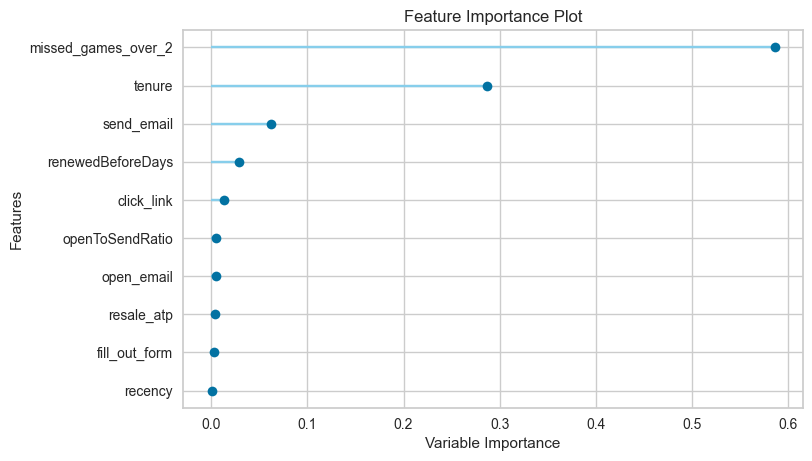

In [117]:
plot_model(best_model, plot='feature')

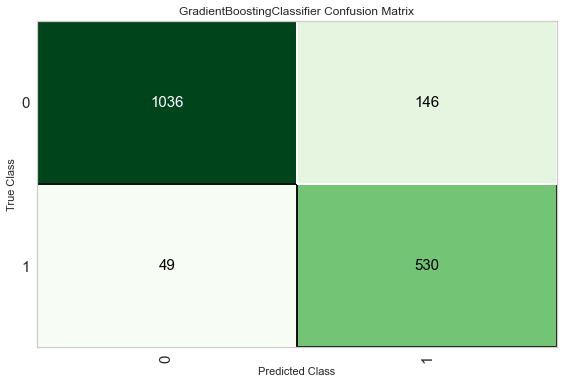

In [119]:
plot_model(best_model, plot='confusion_matrix')

## Results

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?